In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import librosa
import librosa.display
import cv2
import IPython.display as ipd
from tqdm import tqdm
import glob
from scipy import signal as sig
import scipy.fft as fft

In [2]:
def image_creator_freq_domain(signal, hop_length, window_size, nsamples=160,show=False,pre_filter=sig.tukey): # freq_domain
    
    # twindow = sig.tukey(frame_length,(2*hop_length)/frame_length)
    twindow = pre_filter(np.arange(window_size)) ##frame_length,(2*hop_length)/frame_length)
    t_len = len(twindow)
    # plt.figure()
    # plt.plot(twindow)
    # plt.show()
    
    samples = (signal.shape[0])//hop_length
    signal = np.concatenate((signal,np.zeros(window_size)))
    # print(samples)
    if samples<nsamples:
        #print(samples,nsamples)
        signal = np.concatenate((signal,np.zeros((nsamples-samples+window_size//hop_length+1)*hop_length) ))
        
    
    sig_2d = np.zeros((nsamples, t_len))
    
    dct_2d = np.zeros((nsamples, window_size)) 
    # fft_2d_i = np.zeros((samples, 256))
    signal_padded = np.concatenate([signal, np.zeros(t_len)])
    # color_image = np.zeros((samples, 128, 3))
    for i in range(nsamples):
        sig_2d[i, :] = signal_padded[i*hop_length:i*hop_length+t_len]
        # z = np.fft.rfft(sig_2d[i, :])
        f = np.abs(fft.dct(sig_2d[i, :]*twindow))
        f = np.clip(f, 1e-4,100)
        z = np.log10(f)
        # print(len(z))
        # z[0, -1] = 0 + 0j
        dct_2d[i, :] = z
    
    dct_2d[-1,-1] = 2
    dct_2d[-1,-2] = -4
    
    if show:    
        plt.figure()
        plt.imshow(dct_2d, cmap='yet')
        plt.colorbar()
        plt.show()
    
    return dct_2d

In [3]:
def create_audio_dataset_color_test(dirname,cmap='bwr',nsamples=160,window_size=256,hop_length=128,n_expo=4): # '/mnt/datadrive/datasets/google_speech_commands_dct_v1_kf'
    flist = glob.glob('..\..\dataset\google_speech_commands_v0\*\*')
    filter_func = lambda x: 1 - np.cos(x*np.pi/window_size)**n_expo
    # plt.plot(filter_func(np.arange(window_size)))
    # plt.show()
    # print (len(flist))
    dname = f'{dirname}_{cmap}_h{nsamples}_w{window_size*3//4}'

    
    for index in tqdm(range(0, len(flist)), desc =f"Audio Dataset: {dname}"):    
        fname = flist[index]
        word = fname.split('\\')[-2]
        new_filename = f'{dname}/{word}/{index}.jpg'
        new_dir = f'{dname}/{word}'

        signal, sampFreq = librosa.load(fname)
        plt.figure(figsize=(5, 3))
        librosa.display.waveshow(signal, sr=sampFreq)
        plt.show()

        dct_2d = image_creator_freq_domain(signal, hop_length, window_size,pre_filter=filter_func,nsamples=nsamples)
        dct_2d = dct_2d[:,:window_size*3//4]
        print ("image",dct_2d.shape)
        plt.figure(figsize=(3, 5))
        plt.imshow(dct_2d,cmap=cmap)
        plt.title(new_filename)
        plt.show()
        
        break
       
    return dname

Audio Dataset: ../../dataset/audio_dct_bwr_h160_w192:   0%|                                  | 0/64721 [00:00<?, ?it/s]

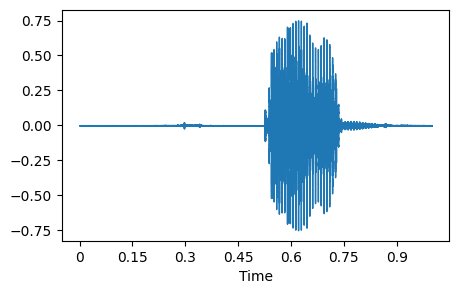

image (160, 192)


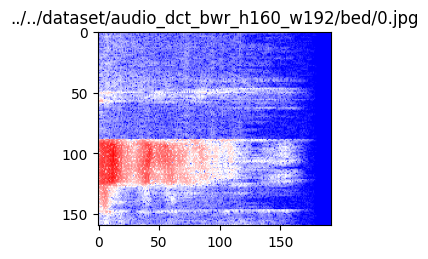

Audio Dataset: ../../dataset/audio_dct_bwr_h160_w192:   0%|                                  | 0/64721 [00:00<?, ?it/s]


'../../dataset/audio_dct_bwr_h160_w192'

In [19]:
create_audio_dataset_color_test('../../dataset/audio_dct',cmap='bwr',n_expo=4)

In [3]:
def create_audio_dataset_color(dirname,cmap='bwr',nsamples=160,window_size=256,hop_length=128,n_expo=4): # '/mnt/datadrive/datasets/google_speech_commands_dct_v1_kf'
    flist = glob.glob('..\..\dataset\google_speech_commands_v0\*\*')
    filter_func = lambda x: 1 - np.cos(x*np.pi/window_size)**n_expo
    # plt.plot(filter_func(np.arange(window_size)))
    # plt.show()
    # print (len(flist))
    dname = f'{dirname}_{cmap}_h{nsamples}_w{window_size*3//4}'

    
    for index in tqdm(range(0, len(flist)), desc =f"Audio Dataset: {dname}"):    
        fname = flist[index]
        word = fname.split('\\')[-2]
        new_filename = f'{dname}/{word}/{index}.jpg'
        new_dir = f'{dname}/{word}'
        os.makedirs(new_dir,exist_ok = True)

        signal, sampFreq = librosa.load(fname)

        dct_2d = image_creator_freq_domain(signal, hop_length, window_size,pre_filter=filter_func,nsamples=nsamples)
        dct_2d = dct_2d[:,:window_size*3//4]
        # print ("image",dct_2d.shape)
        # plt.imshow(dct_2d,cmap=cmap)
        # plt.title(new_filename)
        # plt.show()
        plt.imsave(new_filename,dct_2d,cmap=cmap)
    return dname


In [5]:
nsamples = 160
create_audio_dataset_color('../../dataset/audio_dct',cmap='bwr',n_expo=4,nsamples=nsamples,window_size=256,hop_length=22500//nsamples)

Audio Dataset: ../../dataset/audio_dct_gray_h160_w192: 100%|█████████████████████| 64721/64721 [11:57<00:00, 90.18it/s]


'../../dataset/audio_dct_gray_h160_w192'

In [52]:
def split_dataset_directory(dirname,val_split=.15):
    flist = glob.glob(f'{dirname}\*\*')
    nfiles = len(flist)
    idx = np.random.permutation(np.arange(nfiles))
    val_index = int(nfiles*val_split)
    val_idx = idx[:val_index]
    train_idx = idx[val_index:]
    dest_dir = f'{dirname}_split'
    
    for c,i in enumerate(val_idx):
        fname = flist[i]
        word = fname.split('\\')[-2]
        short_fname = fname.split('\\')[-1]
        new_dname = f'{dest_dir}\\val\\{word}'
        new_fname = f'{dest_dir}\\val\\{word}\\{i}.jpg'
        os.makedirs(new_dname,exist_ok = True)
#         print('fname,--',fname)
#         print('new_fname--',new_fname)
#         print('new_dname--',new_dname)
#         print('short_fname--',short_fname)
        os.symlink(fname,new_fname)
        if c%500 == 0:
            print (c,"val")
            
            
    for c,i in enumerate(train_idx):
        fname = flist[i]
        word = fname.split('\\')[-2]
        short_fname = fname.split('\\')[-1]
        new_dname = f'{dest_dir}\\train\\{word}'
        new_fname = f'{dest_dir}\\train\\{word}\\{i}.jpg'
        os.makedirs(new_dname,exist_ok = True)
        os.symlink(fname,new_fname)
        if c%500 == 0:
            print (c,"train")
        

In [53]:
split_dataset_directory('..\..\dataset\Audio_dct_gray_h160_w192',.05)

0 val
500 val
1000 val
1500 val
2000 val
2500 val
3000 val
0 train
500 train
1000 train
1500 train
2000 train
2500 train
3000 train
3500 train
4000 train
4500 train
5000 train
5500 train
6000 train
6500 train
7000 train
7500 train
8000 train
8500 train
9000 train
9500 train
10000 train
10500 train
11000 train
11500 train
12000 train
12500 train
13000 train
13500 train
14000 train
14500 train
15000 train
15500 train
16000 train
16500 train
17000 train
17500 train
18000 train
18500 train
19000 train
19500 train
20000 train
20500 train
21000 train
21500 train
22000 train
22500 train
23000 train
23500 train
24000 train
24500 train
25000 train
25500 train
26000 train
26500 train
27000 train
27500 train
28000 train
28500 train
29000 train
29500 train
30000 train
30500 train
31000 train
31500 train
32000 train
32500 train
33000 train
33500 train
34000 train
34500 train
35000 train
35500 train
36000 train
36500 train
37000 train
37500 train
38000 train
38500 train
39000 train
39500 train
40000